# Make vehicle type estimation file
use 2017 NHTS to create a choice model estimation file for ActivitySim vehicle type model

Updated vehicle age categories

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_rows = 999
pd.options.display.max_columns = 99
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# read the basic data
hh   = pd.read_csv('hhpub.csv')
pers = pd.read_csv('perpub.csv')
veh  = pd.read_csv('vehpub.csv')


### Calculate several derived fields and merge the HH and person files with the vehicles file

In [3]:
# define person type

def determine_person_type(row):
    
    # children under 5 not included in NHTS data
    if row['R_AGE_IMP']<=4: 
        return 'Child0_4'
    
    # children 5-15
    elif row['R_AGE_IMP']<=15: 
        return 'Child5_15'
    
    # children 16-17
    elif row['R_AGE_IMP']<=17:
        return 'Child16p'
    
    # school type in NHTS stops at age 17, so it's not clear how to identify college students
    elif row['SCHTYP']==1: 
        return 'CollegeStudent'
    
    # full-time workers
    elif row['WKFTPT']==1: 
        return 'FullTimeWorker'
    
    # part-time workers
    elif row['WKFTPT']==2:
        return 'PartTimeWorker'
    
    # non-working adults age <65
    elif row['R_AGE_IMP']<65:
        return 'NonWorkingAdultUnder65'
    
    # non-working adults age >=65
    else:
        return 'NonWorkingAdult65p'

pers['PERSON_TYPE'] = pers.apply(determine_person_type, axis=1)

In [4]:
# define person type count variables
pers['CHILDREN0_4']  = np.where(pers['PERSON_TYPE']=='Child0_4', 1, 0)
pers['CHILDREN5_15'] = np.where(pers['PERSON_TYPE']=='Child5_15', 1, 0)
pers['CHILDREN16P']  = np.where(pers['PERSON_TYPE']=='Child16p', 1, 0)
pers['COLLEGE_STUDENTS']  = np.where(pers['PERSON_TYPE']=='CollegeStudent', 1, 0)
pers['FULL_TIME_WORKERS']  = np.where(pers['PERSON_TYPE']=='FullTimeWorker', 1, 0)
pers['PART_TIME_WORKERS']  = np.where(pers['PERSON_TYPE']=='PartTimeWorker', 1, 0)
pers['NW_ADULTS_UNDER65']  = np.where(pers['PERSON_TYPE']=='NonWorkingAdultUnder65', 1, 0)
pers['NW_ADULTS_65P']  = np.where(pers['PERSON_TYPE']=='NonWorkingAdult65p', 1, 0)


In [5]:
# additional person count variables
pers['CHILDREN'] = np.where(pers['R_AGE_IMP']<18, 1, 0)
pers['WORKERS'] = np.where(((pers['WKFTPT']==1) | (pers['WKFTPT']==2)), 1, 0)
pers['PERSONS16P'] = np.where(pers['R_AGE_IMP']>=16, 1, 0)
pers['DRIVERS'] = np.where(pers['DRIVER']==1,1,0)
pers['MEN16P'] = np.where(((pers['R_AGE_IMP']>=16) & (pers['R_SEX_IMP']==1)), 1, 0)
pers['WOMEN16P'] = np.where(((pers['R_AGE_IMP']>=16) & (pers['R_SEX_IMP']==2)), 1, 0)
pers['BORN_IN_US16P'] = np.where(((pers['R_AGE_IMP']>=16) & (pers['BORNINUS']==1)), 1, 0)
pers['BORN_OUTSIDE_US16P'] = np.where(((pers['R_AGE_IMP']>=16) & (pers['BORNINUS']==2)), 1, 0)


In [6]:
# process distance to work to convert missing values to zeros
pers['DISTTOWK17'] = np.where(pers['DISTTOWK17']<0, 0, pers['DISTTOWK17'])

In [7]:
# aggregate person data to household level
person_specs = {'CHILDREN0_4' : sum, 
                'CHILDREN5_15': sum, 
                'CHILDREN16P': sum, 
                'COLLEGE_STUDENTS': sum, 
                'FULL_TIME_WORKERS': sum, 
                'PART_TIME_WORKERS': sum, 
                'NW_ADULTS_UNDER65': sum, 
                'NW_ADULTS_65P': sum, 
                'WORKERS': sum, 
                'CHILDREN': sum, 
                'PERSONS16P': sum, 
                'DRIVERS': sum, 
                'MEN16P': sum, 
                'WOMEN16P': sum, 
                'BORN_IN_US16P': sum, 
                'BORN_OUTSIDE_US16P': sum, 
                'DISTTOWK17': sum
               }

pershh = pers.groupby('HOUSEID').agg(person_specs)
pershh['DISTTOWK_SUM'] = pershh['DISTTOWK17']
pershh['DISTTOWK_AVG'] = np.where(pershh['WORKERS']>0, pershh['DISTTOWK17'] / pershh['WORKERS'], 0)


In [8]:
# join the household and person files to the vehicle file
estfile = veh.merge(hh, how='left', on='HOUSEID', suffixes=(None, '_x'))
estfile = estfile.merge(pershh, how='left', on='HOUSEID', suffixes=(None, '_x'))

# drop duplicate columns
duplicate_columns = []
for col in estfile.columns: 
    if '_x' in col: 
        duplicate_columns.append(col)
estfile = estfile.drop(columns=duplicate_columns)

### Group the alternatives into more aggregate categories, and drop records missing our choice alternatives

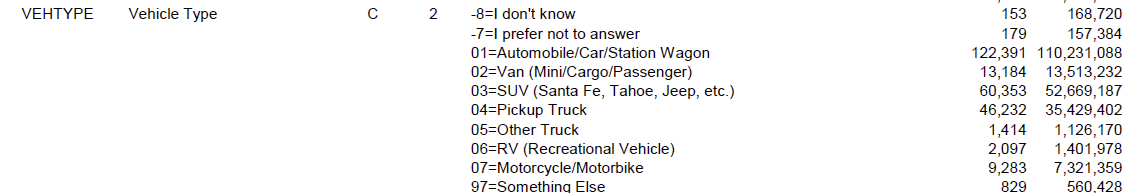

In [9]:
# group body types into more limited categories
def determine_body_type(row):
    
    # automobile/car/station wagon
    if row['VEHTYPE']==1: 
        return 1
    
    # van (Mini/Cargo/Passenger)
    elif row['VEHTYPE']==2: 
        return 2
    
    # SUV
    elif row['VEHTYPE']==3: 
        return 3
    
    # pickup/other truck
    elif row['VEHTYPE']==4 or row['VEHTYPE']==5: 
        return 4
    
    # motorcycle
    elif row['VEHTYPE']==7: 
        return 5
    
    # everything else
    else: 
        return 97
    
estfile['VEHTYPE2'] = estfile.apply(determine_body_type, axis=1)
estfile['VEHTYPE2_TXT'] = estfile['VEHTYPE2'].replace({1:'1-Car', 
                                                       2:'2-Van', 
                                                       3:'3-SUV', 
                                                       4:'4-Pickup/Truck', 
                                                       5:'5-Motorcycle', 
                                                       97:'97-Other'})

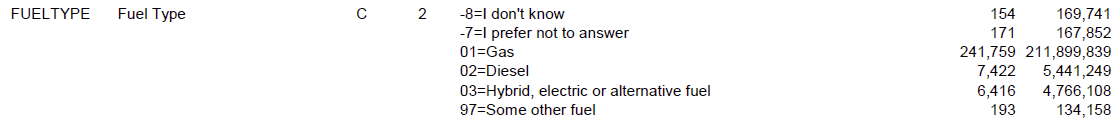
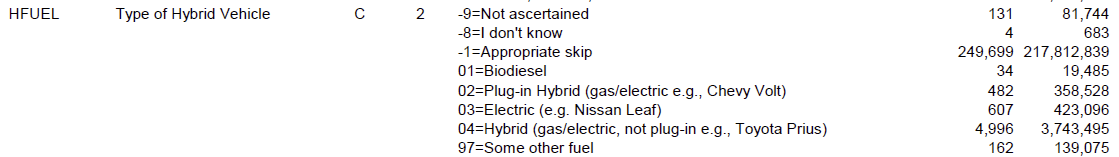

In [10]:
# group fuel types into a more limited number of categories
def determine_fuel_type(row):
    
    # gas
    if row['FUELTYPE']==1:
        return 1
    
    # diesel
    if row['FUELTYPE']==2: 
        return 2
    
    # hybrid
    elif row['FUELTYPE']==3 and row['HFUEL']==4: 
        return 3
    
    # plug-in hybrid
    elif row['FUELTYPE']==3 and row['HFUEL']==2: 
        return 4
    
    # battery-electric
    elif row['FUELTYPE']==3 and row['HFUEL']==3: 
        return 5
    
    # don't know/other
    else:
        return 97
    
estfile['FUELTYPE2'] = estfile.apply(determine_fuel_type, axis=1)
estfile['FUELTYPE2_TXT'] = estfile['FUELTYPE2'].replace({1:'1-Gas', 
                                                         2:'2-Diesel',
                                                         3:'3-Hybrid', 
                                                         4:'4-Plug-In Hybrid', 
                                                         5:'5-Battery Electric', 
                                                         97:'97-Other'})

In [11]:
# group vehicle ages into a more limited number of categories
def determine_vehicle_age_group(row):
    
    if row['VEHAGE']<0:
        return 97
    elif row['VEHAGE']<=5: 
        return 1
    elif row['VEHAGE']<=10:
        return 2
    else:
        return 3
    
estfile['VEHAGE2'] = estfile.apply(determine_vehicle_age_group, axis=1)
estfile['VEHAGE2_TXT'] = estfile['VEHAGE2'].replace({1:'1: 1-5 years', 
                                                     2:'2: 6-10 years', 
                                                     3:'3: 11+ years', 
                                                    97:'97: Missing/Unknown'})

In [12]:
# group vehicle ages into new vs used
# we probably won't use this, but it will be interesting for future use
estfile['NEW_VEHICLE'] = np.where(estfile['VEHOWNED']==2, 1, 0)

In [13]:
# exclude missing body types, fuel types, and age
estfile = estfile[estfile['VEHTYPE2']!=97]
estfile = estfile[estfile['FUELTYPE2']!=97]
estfile = estfile[estfile['VEHAGE2']!=97]

# exclude diesel, hybrid, and PEV motorcyles b/c a tiny share and of little interest
estfile = estfile[(estfile['VEHTYPE2']!=5) | (estfile['FUELTYPE2']!=2)]
estfile = estfile[(estfile['VEHTYPE2']!=5) | (estfile['FUELTYPE2']!=3)]
estfile = estfile[(estfile['VEHTYPE2']!=5) | (estfile['FUELTYPE2']!=3)]

### Rank vehicles by how many miles they are driven

In [14]:
# rank vehicles by miles driven
estfile["RANK"] = estfile.groupby("HOUSEID")["BESTMILE"].rank("first", ascending=False)

In [15]:
# stats by rank of vehicles
pd.pivot_table(estfile, 
               index=['RANK'], 
               values=['BESTMILE'], 
               aggfunc=['count', 'mean', 'sum'], 
               fill_value=0)

,count,mean,sum
,BESTMILE,BESTMILE,BESTMILE
RANK,,,
1.00,123059,"14,383.74","1,770,048,674.88"
2.00,80940,"8,064.07","652,705,614.37"
3.00,30478,"5,274.67","160,761,301.92"
4.00,10677,"3,721.19","39,731,138.59"
5.00,3589,"2,678.66","9,613,721.57"
6.00,1289,"1,985.13","2,558,828.89"
7.00,507,"1,547.02","784,339.38"
8.00,239,"1,391.59","332,589.11"


In [16]:
# stats by rank of vehicles
pd.pivot_table(estfile, 
               index=['RANK'], 
               columns=['PERSONS16P'], 
               values=['BESTMILE'], 
               aggfunc=['count', 'mean'], 
               fill_value=0)

count                                                 mean  \
           BESTMILE                                             BESTMILE   
PERSONS16P       1      2      3     4    5    6   7  8  9  10        1    
RANK                                                                       
1.00          39462  67925  11473  3327  679  149  33  9  1  1 10,891.85   
2.00           8930  57518  10537  3141  633  141  30  8  1  1  5,523.80   
3.00           2278  17560   7339  2591  546  126  29  7  1  1  3,411.98   
4.00            711   5253   2549  1633  398  102  24  5  1  1  2,430.41   
5.00            250   1695    808   532  213   72  14  3  1  1  1,749.16   
6.00            103    620    263   179   78   33   9  2  1  1  1,621.77   
7.00             58    238    107    61   28    8   4  1  1  1  1,514.12   
8.00             37    113     50    21    9    6   1  1  0  1  1,314.68   
9.00             23     62     21     7    6    3   1  0  0  1  1,469.89   
10.00            16     31      9     4    0    1   1  0  0  1  1,514.99   
11.00            12     16      5     1    0    1   0  0  0  1    427.64   
12.00             8     12      2     1    0    1   0  0  0  0    308.18   

                                                                        \
                                                                         
PERSONS16P        2         3         4         5         6         7    
RANK                                                                     
1.00       15,362.13 18,396.79 20,151.35 21,003.49 23,180.00 21,740.13   
2.00        7,810.98 10,103.87 11,736.08 12,708.04 15,017.81 16,066.22   
3.00        4,492.61  6,379.75  7,987.36  8,903.97 10,414.02 10,572.08   
4.00        2,832.80  4,150.10  5,489.00  6,409.65  7,385.50  8,657.05   
5.00        1,949.79  2,806.50  3,846.86  4,791.05  5,619.76  5,996.89   
6.00        1,470.28  2,095.32  2,519.19  3,303.61  4,063.38  5,973.11   
7.00        1,218.14  1,640.20  1,579.06  2,684.00  3,459.32  3,563.82   
8.00        1,145.48  1,426.12  1,337.94  2,697.95  3,210.29  5,262.86   
9.00          847.42    734.03  1,766.74  2,540.91  1,523.91  3,749.67   
10.00       1,023.39  1,039.39  1,002.56      0.00  1,000.00      0.00   
11.00         966.01    715.80  2,366.65      0.00    831.03      0.00   
12.00         532.10     33.27     -9.00      0.00    669.54      0.00   

                                          
                                          
PERSONS16P        8         9         10  
RANK                                      
1.00       18,733.15 13,976.40 36,661.69  
2.00       12,724.64 13,415.37 19,899.77  
3.00       10,265.94 12,291.49 17,805.46  
4.00        8,302.25 10,984.36 15,649.61  
5.00        7,961.05 10,721.89 13,679.38  
6.00        6,813.11  5,867.99 13,179.99  
7.00        1,500.00  5,567.18 10,630.68  
8.00          300.00      0.00  5,997.62  
9.00            0.00      0.00  5,783.77  
10.00           0.00      0.00  1,834.00  
11.00           0.00      0.00  1,471.78  
12.00           0.00      0.00      0.00

In [17]:
# keep only the four vehicles in each household (limit of ActivitySim car ownership model)
# keep the vehicles that have the most mileage

estfile = estfile[estfile['RANK']<=4]

In [18]:
estfile.head()

,HOUSEID,VEHID,VEHYEAR,VEHAGE,MAKE,MODEL,FUELTYPE,VEHTYPE,WHOMAIN,OD_READ,HFUEL,VEHOWNED,VEHOWNMO,ANNMILES,HYBRID,PERSONID,TRAVDAY,HOMEOWN,HHSIZE,HHVEHCNT,HHFAMINC,DRVRCNT,HHSTATE,HHSTFIPS,NUMADLT,WRKCOUNT,TDAYDATE,LIF_CYC,MSACAT,MSASIZE,RAIL,URBAN,URBANSIZE,URBRUR,CENSUS_D,CENSUS_R,CDIVMSAR,HH_RACE,HH_HISP,HH_CBSA,SMPLSRCE,WTHHFIN,BESTMILE,BEST_FLG,BEST_EDT,BEST_OUT,HBHUR,HTHTNRNT,HTPPOPDN,...,PC,SPHONE,TAB,WALK,BIKE,CAR,TAXI,BUS,TRAIN,PARA,PRICE,PLACE,WALK2SAVE,BIKE2SAVE,PTRANS,HHRELATD,CNTTDHH,YOUNGCHILD,HHRESP,SCRESP,RESP_CNT,WEBUSE17,CHILDREN0_4,CHILDREN5_15,CHILDREN16P,COLLEGE_STUDENTS,FULL_TIME_WORKERS,PART_TIME_WORKERS,NW_ADULTS_UNDER65,NW_ADULTS_65P,WORKERS,CHILDREN,PERSONS16P,DRIVERS,MEN16P,WOMEN16P,BORN_IN_US16P,BORN_OUTSIDE_US16P,DISTTOWK17,DISTTOWK_SUM,DISTTOWK_AVG,VEHTYPE2,VEHTYPE2_TXT,FUELTYPE2,FUELTYPE2_TXT,VEHAGE2,VEHAGE2_TXT,NEW_VEHICLE,RANK
0,30000007,1,2007,10,49,49032,1,1,3,69000,-1,1,-1,1000,2,3,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.31,"14,611.93",1,-1,4,T,50,1500,...,2,1,2,5,5,1,5,4,5,5,1,2,4,4,4,1,6,0,1,1,3,1,0,0,0,0,1,0,1,1,1,0,3,3,1,2,3,0,82.61,82.61,82.61,1,1-Car,1,1-Gas,2,2: 6-10 years,0,1.00
1,30000007,2,2004,13,49,49442,1,2,-8,164000,-1,1,-1,2500,2,-8,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.31,"4,767.09",3,-1,-1,T,50,1500,...,2,1,2,5,5,1,5,4,5,5,1,2,4,4,4,1,6,0,1,1,3,1,0,0,0,0,1,0,1,1,1,0,3,3,1,2,3,0,82.61,82.61,82.61,2,2-Van,1,1-Gas,3,3: 11+ years,0,4.00
2,30000007,3,1998,19,19,19014,1,1,1,120000,-1,1,-1,900,2,1,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.31,"8,000.32",1,-1,-1,T,50,1500,...,2,1,2,5,5,1,5,4,5,5,1,2,4,4,4,1,6,0,1,1,3,1,0,0,0,0,1,0,1,1,1,0,3,3,1,2,3,0,82.61,82.61,82.61,1,1-Car,1,1-Gas,3,3: 11+ years,0,3.00
4,30000007,5,1993,24,20,20481,1,4,2,300000,-1,1,-1,10000,2,2,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.31,"12,437.66",1,-1,-1,T,50,1500,...,2,1,2,5,5,1,5,4,5,5,1,2,4,4,4,1,6,0,1,1,3,1,0,0,0,0,1,0,1,1,1,0,3,3,1,2,3,0,82.61,82.61,82.61,4,4-Pickup/Truck,1,1-Gas,3,3: 11+ years,0,2.00
5,30000008,1,2014,3,20,20028,1,1,97,-88,-1,1,-1,8000,2,97,5,1,2,4,8,2,WI,55,2,2,201608,2,2,5,2,4,6,2,3,2,32,1,2,33460,2,69.51,"6,099.62",3,-1,-1,R,5,300,...,1,1,2,4,4,1,5,5,5,5,5,2,4,4,5,1,2,0,2,1,2,1,0,0,0,0,2,0,0,0,2,0,2,2,1,1,2,0,11.18,11.18,5.59,1,1-Car,1,1-Gas,1,1: 1-5 years,0,4.00


### Based on the rank of the vehicles, determine the types of vehicles already owned

In [19]:
# first create flags based on the vehicle types

ownership_data = estfile[['HOUSEID', 'RANK', 'VEHTYPE2', 'FUELTYPE2']].copy()

# vehicle type
ownership_data['CARS'] = np.where(ownership_data['VEHTYPE2']==1, 1, 0)
ownership_data['VANS'] = np.where(ownership_data['VEHTYPE2']==2, 1, 0)
ownership_data['SUVS'] = np.where(ownership_data['VEHTYPE2']==3, 1, 0)
ownership_data['PUS']  = np.where(ownership_data['VEHTYPE2']==4, 1, 0)
ownership_data['MCS']  = np.where(ownership_data['VEHTYPE2']==5, 1, 0)

# fuel type
ownership_data['GASS'] = np.where(ownership_data['FUELTYPE2']==1, 1, 0)
ownership_data['DSLS'] = np.where(ownership_data['FUELTYPE2']==2, 1, 0)
ownership_data['HYBS'] = np.where(ownership_data['FUELTYPE2']==3, 1, 0)
ownership_data['PEVS'] = np.where(ownership_data['FUELTYPE2']==4, 1, 0)
ownership_data['BEVS'] = np.where(ownership_data['FUELTYPE2']==5, 1, 0)

ownership_data = ownership_data.drop(columns=['VEHTYPE2', 'FUELTYPE2'])

In [20]:
# create fields for count of vehicles and initialize with zeros
# for vehicle rank 1, this always stays at zero

estfile['CAR_COUNT'] = 0
estfile['VAN_COUNT'] = 0
estfile['SUV_COUNT'] = 0
estfile['PU_COUNT'] = 0
estfile['MC_COUNT'] = 0

estfile['GAS_COUNT'] = 0
estfile['DSL_COUNT'] = 0
estfile['HYB_COUNT'] = 0
estfile['PEV_COUNT'] = 0
estfile['BEV_COUNT'] = 0

In [21]:
# for rank 2 vehicles, only count the number of rank 1 vehicles

rank1_ownership = ownership_data[ownership_data['RANK']==1]
rank1_counts = rank1_ownership.groupby('HOUSEID').agg(sum).reset_index()
estfile = estfile.merge(rank1_counts, how='left', on='HOUSEID', suffixes=(None, '_x'))

estfile['CAR_COUNT'] = np.where(estfile['RANK']==2, estfile['CARS'], estfile['CAR_COUNT'])
estfile['VAN_COUNT'] = np.where(estfile['RANK']==2, estfile['VANS'], estfile['VAN_COUNT'])
estfile['SUV_COUNT'] = np.where(estfile['RANK']==2, estfile['SUVS'], estfile['SUV_COUNT'])
estfile['PU_COUNT']  = np.where(estfile['RANK']==2, estfile['PUS'],  estfile['PU_COUNT'])
estfile['MC_COUNT']  = np.where(estfile['RANK']==2, estfile['MCS'],  estfile['MC_COUNT'])

estfile['GAS_COUNT'] = np.where(estfile['RANK']==2, estfile['GASS'], estfile['GAS_COUNT'])
estfile['DSL_COUNT'] = np.where(estfile['RANK']==2, estfile['DSLS'], estfile['DSL_COUNT'])
estfile['HYB_COUNT'] = np.where(estfile['RANK']==2, estfile['HYBS'], estfile['HYB_COUNT'])
estfile['PEV_COUNT'] = np.where(estfile['RANK']==2, estfile['PEVS'], estfile['PEV_COUNT'])
estfile['BEV_COUNT'] = np.where(estfile['RANK']==2, estfile['BEVS'], estfile['BEV_COUNT'])

estfile = estfile.drop(columns=['CARS', 'VANS', 'SUVS', 'PUS', 'MCS', 'GASS', 'DSLS', 'HYBS', 'PEVS', 'BEVS'])

In [22]:
# for rank 3 vehicles, only count the number of rank 1 AND 2 vehicles

rank2_ownership = ownership_data[ownership_data['RANK']<=2]
rank2_counts = rank2_ownership.groupby('HOUSEID').agg(sum).reset_index()
estfile = estfile.merge(rank2_counts, how='left', on='HOUSEID', suffixes=(None, '_x'))

estfile['CAR_COUNT'] = np.where(estfile['RANK']==3, estfile['CARS'], estfile['CAR_COUNT'])
estfile['VAN_COUNT'] = np.where(estfile['RANK']==3, estfile['VANS'], estfile['VAN_COUNT'])
estfile['SUV_COUNT'] = np.where(estfile['RANK']==3, estfile['SUVS'], estfile['SUV_COUNT'])
estfile['PU_COUNT']  = np.where(estfile['RANK']==3, estfile['PUS'],  estfile['PU_COUNT'])
estfile['MC_COUNT']  = np.where(estfile['RANK']==3, estfile['MCS'],  estfile['MC_COUNT'])

estfile['GAS_COUNT'] = np.where(estfile['RANK']==3, estfile['GASS'], estfile['GAS_COUNT'])
estfile['DSL_COUNT'] = np.where(estfile['RANK']==3, estfile['DSLS'], estfile['DSL_COUNT'])
estfile['HYB_COUNT'] = np.where(estfile['RANK']==3, estfile['HYBS'], estfile['HYB_COUNT'])
estfile['PEV_COUNT'] = np.where(estfile['RANK']==3, estfile['PEVS'], estfile['PEV_COUNT'])
estfile['BEV_COUNT'] = np.where(estfile['RANK']==3, estfile['BEVS'], estfile['BEV_COUNT'])

estfile = estfile.drop(columns=['CARS', 'VANS', 'SUVS', 'PUS', 'MCS', 'GASS', 'DSLS', 'HYBS', 'PEVS', 'BEVS'])

In [23]:
# for rank 4 vehicles, count the number of rank 1, 2 AND 2 vehicles

rank3_ownership = ownership_data[ownership_data['RANK']<=3]
rank3_counts = rank3_ownership.groupby('HOUSEID').agg(sum).reset_index()
estfile = estfile.merge(rank3_counts, how='left', on='HOUSEID', suffixes=(None, '_x'))

estfile['CAR_COUNT'] = np.where(estfile['RANK']==4, estfile['CARS'], estfile['CAR_COUNT'])
estfile['VAN_COUNT'] = np.where(estfile['RANK']==4, estfile['VANS'], estfile['VAN_COUNT'])
estfile['SUV_COUNT'] = np.where(estfile['RANK']==4, estfile['SUVS'], estfile['SUV_COUNT'])
estfile['PU_COUNT']  = np.where(estfile['RANK']==4, estfile['PUS'],  estfile['PU_COUNT'])
estfile['MC_COUNT']  = np.where(estfile['RANK']==4, estfile['MCS'],  estfile['MC_COUNT'])

estfile['GAS_COUNT'] = np.where(estfile['RANK']==4, estfile['GASS'], estfile['GAS_COUNT'])
estfile['DSL_COUNT'] = np.where(estfile['RANK']==4, estfile['DSLS'], estfile['DSL_COUNT'])
estfile['HYB_COUNT'] = np.where(estfile['RANK']==4, estfile['HYBS'], estfile['HYB_COUNT'])
estfile['PEV_COUNT'] = np.where(estfile['RANK']==4, estfile['PEVS'], estfile['PEV_COUNT'])
estfile['BEV_COUNT'] = np.where(estfile['RANK']==4, estfile['BEVS'], estfile['BEV_COUNT'])

estfile = estfile.drop(columns=['CARS', 'VANS', 'SUVS', 'PUS', 'MCS', 'GASS', 'DSLS', 'HYBS', 'PEVS', 'BEVS'])

### look at options for how we might structure the alternatives for each, consider the count of observations and the average miles driven per vehicle

In [24]:
# vehicle type by fuel type
pd.pivot_table(estfile, 
               index=['VEHTYPE2_TXT'], 
               columns=['FUELTYPE2_TXT'], 
               values=['BESTMILE'], 
               aggfunc=['count', 'mean'], 
               fill_value=0)

count                                                        \
               BESTMILE                                                         
FUELTYPE2_TXT     1-Gas 2-Diesel 3-Hybrid 4-Plug-In Hybrid 5-Battery Electric   
VEHTYPE2_TXT                                                                    
1-Car            113366     1158     4416              434                450   
2-Van             12836       94       14                3                  1   
3-SUV             58623      375      520               21                 12   
4-Pickup/Truck    40907     5044       10                0                  1   
5-Motorcycle       6850        0        0                0                 19   

                    mean                                       \
                BESTMILE                                        
FUELTYPE2_TXT      1-Gas  2-Diesel  3-Hybrid 4-Plug-In Hybrid   
VEHTYPE2_TXT                                                    
1-Car          10,565.16 11,984.98 12,752.93        12,073.42   
2-Van          11,751.09 14,545.47 20,616.30         7,074.17   
3-SUV          11,878.62 12,407.97 11,806.29        12,770.84   
4-Pickup/Truck 10,077.71 12,186.25 14,223.92             0.00   
5-Motorcycle    1,676.68      0.00      0.00             0.00   

                                   
                                   
FUELTYPE2_TXT  5-Battery Electric  
VEHTYPE2_TXT                       
1-Car                   10,337.94  
2-Van                   10,168.93  
3-SUV                    9,808.94  
4-Pickup/Truck              -9.00  
5-Motorcycle             1,175.26

In [25]:
# segmenting by vehicle age, like we initially proposed

pd.pivot_table(estfile, 
               index=['VEHTYPE2_TXT','FUELTYPE2_TXT'], 
               columns=['VEHAGE2_TXT'],
               values=['BESTMILE'], 
               aggfunc=['count', 'mean'], 
               fill_value=0)

count                             \
                                      BESTMILE                              
VEHAGE2_TXT                       1: 1-5 years 2: 6-10 years 3: 11+ years   
VEHTYPE2_TXT   FUELTYPE2_TXT                                                
1-Car          1-Gas                     36224         30160        46982   
               2-Diesel                    518           242          398   
               3-Hybrid                   2382          1537          497   
               4-Plug-In Hybrid            406            24            4   
               5-Battery Electric          416            28            6   
2-Van          1-Gas                      3460          3177         6199   
               2-Diesel                     29            14           51   
               3-Hybrid                     11             1            2   
               4-Plug-In Hybrid              3             0            0   
               5-Battery Electric            1             0            0   
3-SUV          1-Gas                     25692         14632        18299   
               2-Diesel                    212            47          116   
               3-Hybrid                    204           223           93   
               4-Plug-In Hybrid             17             4            0   
               5-Battery Electric           11             0            1   
4-Pickup/Truck 1-Gas                      9093          7722        24092   
               2-Diesel                   1195           898         2951   
               3-Hybrid                      3             4            3   
               5-Battery Electric            1             0            0   
5-Motorcycle   1-Gas                      1398          1670         3782   
               5-Battery Electric           12             7            0   

                                          mean                             
                                      BESTMILE                             
VEHAGE2_TXT                       1: 1-5 years 2: 6-10 years 3: 11+ years  
VEHTYPE2_TXT   FUELTYPE2_TXT                                               
1-Car          1-Gas                 12,516.13     11,110.57     8,710.81  
               2-Diesel              13,924.23     13,171.44     8,739.61  
               3-Hybrid              13,460.58     12,162.66    11,186.80  
               4-Plug-In Hybrid      12,102.02     12,642.20     5,757.40  
               5-Battery Electric    10,549.84      8,849.96     2,590.63  
2-Van          1-Gas                 14,646.53     12,563.50     9,718.63  
               2-Diesel              22,296.71     14,611.20    10,119.87  
               3-Hybrid              12,689.97     18,248.07    65,395.20  
               4-Plug-In Hybrid       7,074.17          0.00         0.00  
               5-Battery Electric    10,168.93          0.00         0.00  
3-SUV          1-Gas                 13,223.77     12,139.16     9,781.68  
               2-Diesel              13,236.42     16,141.80     9,381.07  
               3-Hybrid              12,555.07     11,295.89    11,387.69  
               4-Plug-In Hybrid      12,814.30     12,586.14         0.00  
               5-Battery Electric    10,422.81          0.00     3,056.36  
4-Pickup/Truck 1-Gas                 13,643.15     11,415.48     8,303.23  
               2-Diesel              17,780.50     13,681.79     9,465.78  
               3-Hybrid              12,063.58     21,499.08     6,684.04  
               5-Battery Electric        -9.00          0.00         0.00  
5-Motorcycle   1-Gas                  2,930.39      1,788.78     1,163.74  
               5-Battery Electric     1,441.58        718.71         0.00

In [26]:
# body type by age, with more detailed age groups

pd.pivot_table(estfile, 
               index=['VEHAGE'], 
               columns=['VEHTYPE2_TXT'], 
               values=['BESTMILE'], 
               aggfunc=['count', 'mean'], 
               fill_value=0)

count                                              mean  \
             BESTMILE                                          BESTMILE   
VEHTYPE2_TXT    1-Car 2-Van 3-SUV 4-Pickup/Truck 5-Motorcycle     1-Car   
VEHAGE                                                                    
1                6775   569  6204           2119          220 12,938.23   
2                8012   697  6130           2365          273 13,822.24   
3                8385   812  5143           2168          312 11,684.34   
4                8876   659  4713           1912          283 12,266.46   
5                7898   767  3946           1728          322 12,245.10   
6                5979   595  3594           1711          191 11,512.40   
7                6488   632  2916           1549          239 11,276.62   
8                5753   443  2139           1284          384 11,046.84   
9                6900   772  3227           1938          408 11,194.09   
10               6871   750  3030           2142          455 10,877.66   
11               6367   940  2685           2355          437 10,015.13   
12               5895   972  2588           2468          415  9,667.66   
13               5028   626  2653           2531          315  9,760.17   
14               4567   560  2166           2304          352  9,299.41   
15               4026   559  1741           2185          273  9,214.07   
16               3661   487  1403           2115          257  8,334.54   
17               3256   531  1149           1851          245  8,096.70   
18               2437   338  1029           1575          163  8,146.83   
19               2001   245   695           1305          123  8,005.47   
20               1576   173   561           1243           90  8,105.27   
21               1112   132   347            919           94  7,637.22   
22               1062   150   322            917           85  7,634.05   
23                758    83   203            767           49  7,385.61   
24                621    75   133            578           62  7,756.42   
25                473    51   101            456           43  7,286.57   
26                417    46    87            335           29  7,648.01   
27                376    47    79            345           38  7,069.05   
28                289    36    64            347           32  7,105.14   
29                256    26    45            262           32  5,989.92   
30                229    24    67            226           45  5,920.41   
31                203    18    55            214           61  6,258.66   
32                200    23    45            187           57  6,227.57   
40               3077   110   291           1561          485  6,383.12   

                                                              
                                                              
VEHTYPE2_TXT     2-Van     3-SUV 4-Pickup/Truck 5-Motorcycle  
VEHAGE                                                        
1            15,039.98 13,637.16      15,263.09     4,644.90  
2            17,956.61 13,647.49      15,464.36     3,241.04  
3            13,188.39 12,517.85      13,299.68     2,665.48  
4            13,871.97 13,081.53      12,956.72     2,589.41  
5            13,781.58 12,962.07      13,205.06     1,996.51  
6            13,147.58 12,464.79      12,197.94     1,717.02  
7            12,760.13 12,269.32      12,723.50     1,769.18  
8            12,863.11 11,797.46      10,998.62     1,675.70  
9            12,586.43 12,082.28      11,311.82     2,188.00  
10           11,779.67 11,930.08      11,157.17     1,550.19  
11           10,677.98 11,037.71       9,914.32     1,455.23  
12           10,993.46 10,817.88       9,604.96     1,318.98  
13           11,102.55 10,339.91       9,494.68     1,299.25  
14            9,527.74  9,897.84       9,309.14     1,338.34  
15           10,907.40 10,024.09       9,529.10     1,295.92  
16            8,913.37  9,121.13       8,48

From the above tables, we can make three observations:

1. There are no very many plug-in hybrids or battery electric vehicles.  Consider merging these groups. 
2. Motorcycles are not driven very many miles.  I would consider dropping them, but that might be problematic if they are already counted in ActivitySim's car ownership model.  
3. New cars are driven more miles per year than old cars.  Is it worth keeping vehicle age? 
4. There are some old cars on the road!

Based on this, keep motorcycles for now, and carry forward either the option with age groups, or with no age consideration.

In [27]:
# code simple choice option
estfile['CHOICE1'] = 10*estfile['VEHTYPE2'] + estfile['FUELTYPE2']

estfile['CHOICE1_TXT'] = estfile['CHOICE1'].replace({11:'Car-Gas', 
                                                     12:'Car-Diesel',
                                                     13:'Car-Hybrid',
                                                     14:'Car-PEV',
                                                     15:'Car-BEV',
                                                     21:'Van-Gas', 
                                                     22:'Van-Diesel',
                                                     23:'Van-Hybrid', 
                                                     24:'Van-PEV',    
                                                     25:'Van-BEV',
                                                     31:'SUV-Gas',   
                                                     32:'SUV-Diesel',
                                                     33:'SUV-Hybrid',
                                                     34:'SUV-PEV', 
                                                     35:'SUV-BEV',
                                                     41:'Pickup-Gas', 
                                                     42:'Pickup-Diesel',
                                                     43:'Pickup-Hybrid', 
                                                     44:'Pickup-PEV', 
                                                     45:'Pickup-BEV',
                                                     51:'Motorcycle-Gas', 
                                                     52:'Motorcycle-Diesel',
                                                     53:'Motorcycle-Hybrid', 
                                                     54:'Motorcycle-PEV',
                                                     55:'Motorcycle-BEV'
                                                     })

In [28]:
# code choice option with age
estfile['CHOICE2'] = 100*estfile['VEHTYPE2'] + 10*estfile['FUELTYPE2'] + estfile['VEHAGE2'] 

estfile['CHOICE2_TXT'] = estfile['CHOICE2'].replace({111:'Car-Gas-Age15', 
                                                     112:'Car-Gas-Age610', 
                                                     113:'Car-Gas-Age11P', 
                                                     121:'Car-Diesel-Age15',
                                                     122:'Car-Diesel-Age610',
                                                     123:'Car-Diesel-Age11P',                                                                                                 
                                                     131:'Car-Hybrid-Age15',                                                                                                      
                                                     132:'Car-Hybrid-Age610',                                                                                                     
                                                     133:'Car-Hybrid-Age11P',                                                   
                                                     141:'Car-PEV-Age15',                                               
                                                     142:'Car-PEV-Age610',                                               
                                                     143:'Car-PEV-Age11P',                                                    
                                                     151:'Car-BEV-Age15',                                               
                                                     152:'Car-BEV-Age610',                                               
                                                     153:'Car-BEV-Age11P',     

                                                     211:'Van-Gas-Age15', 
                                                     212:'Van-Gas-Age610', 
                                                     213:'Van-Gas-Age11P', 
                                                     221:'Van-Diesel-Age15',
                                                     222:'Van-Diesel-Age610',
                                                     223:'Van-Diesel-Age11P',                                                                                                     
                                                     231:'Van-Hybrid-Age15',                                                                                                      
                                                     232:'Van-Hybrid-Age610',                                                                                                     
                                                     233:'Van-Hybrid-Age11P',                                                     
                                                     241:'Van-PEV-Age15',                                               
                                                     242:'Van-PEV-Age610',                                               
                                                     243:'Van-PEV-Age11P',                                                     
                                                     251:'Van-BEV-Age15',                                               
                                                     252:'Van-BEV-Age610',                                               
                                                     253:'Van-BEV-Age11P',   

                                                     311:'SUV-Gas-Age15', 
                                                     312:'SUV-Gas-Age610', 
                                                     313:'SUV-Gas-Age11P', 
                                                     321:'SUV-Diesel-Age15',
                                                     322:'SUV-Diesel-Age610',
                                                     323:'SUV-Diesel-Age11P',                                                                                                     
                                                     331:'SUV-Hybrid-Age15',                                                                                                      
                                                     332:'SUV-Hybrid-Age610',                                                                                                     
                                                     333:'SUV-Hybrid-Age11P',                                                     
                                                     341:'SUV-PEV-Age15',                                               
                                                     342:'SUV-PEV-Age610',                                               
                                                     343:'SUV-PEV-Age11P',                                                
                                                     351:'SUV-BEV-Age15',                                               
                                                     352:'SUV-BEV-Age610',                                               
                                                     353:'SUV-BEV-Age11P',       
                                                     
                                                     411:'Pickup-Gas-Age15', 
                                                     412:'Pickup-Gas-Age610', 
                                                     413:'Pickup-Gas-Age11P', 
                                                     421:'Pickup-Diesel-Age15',
                                                     422:'Pickup-Diesel-Age610',
                                                     423:'Pickup-Diesel-Age11P',                                                                                                  
                                                     431:'Pickup-Hybrid-Age15',                                                                                                   
                                                     432:'Pickup-Hybrid-Age610',                                                                                                      
                                                     433:'Pickup-Hybrid-Age11P',                                                   
                                                     441:'Pickup-PEV-Age15',                                               
                                                     442:'Pickup-PEV-Age610',                                               
                                                     443:'Pickup-PEV-Age11P',                                                
                                                     451:'Pickup-BEV-Age15',                                               
                                                     452:'Pickup-BEV-Age610',                                               
                                                     453:'Pickup-BEV-Age11P',     

                                                     511:'Motorcycle-Gas-Age15', 
                                                     512:'Motorcycle-Gas-Age610', 
                                                     513:'Motorcycle-Gas-Age11P', 
                                                     521:'Motorcycle-Diesel-Age15',
                                                     522:'Motorcycle-Diesel-Age610',
                                                     523:'Motorcycle-Diesel-Age11P',                                                                                                  
                                                     531:'Motorcycle-Hybrid-Age15',                                                                                                   
                                                     532:'Motorcycle-Hybrid-Age610',                                                                                                      
                                                     533:'Motorcycle-Hybrid-Age11P',                                                  
                                                     541:'Motorcycle-PEV-Age15',                                               
                                                     542:'Motorcycle-PEV-Age610',                                               
                                                     543:'Motorcycle-PEV-Age11P',                                                      
                                                     551:'Motorcycle-BEV-Age15',                                               
                                                     552:'Motorcycle-BEV-Age610',                                               
                                                     553:'Motorcycle-BEV-Age11P',     
                                                     })

In [29]:
# code choice option of body type by detailed age

# cap vehicle age at 20+
estfile['VEHAGE_C20'] = estfile['VEHAGE'].apply(lambda x : min(x,20))

# choice3 is vehicle type by age
estfile['CHOICE3'] = 100*estfile['VEHTYPE2'] + estfile['VEHAGE_C20']


In [30]:
# body type and fuel type by detailed age

pd.pivot_table(estfile, 
               index=['VEHTYPE2_TXT','FUELTYPE2_TXT'], 
               columns=['VEHAGE_C20'],
               values=['BESTMILE'], 
               aggfunc=['count', 'mean'], 
               fill_value=0)

count                                \
                                  BESTMILE                                 
VEHAGE_C20                              1     2     3     4     5     6    
VEHTYPE2_TXT   FUELTYPE2_TXT                                               
1-Car          1-Gas                  6248  7287  7576  7941  7172  5604   
               2-Diesel                 13    96   138   148   123    79   
               3-Hybrid                313   440   504   615   510   259   
               4-Plug-In Hybrid        101    66    93    95    51    11   
               5-Battery Electric      100   123    74    77    42    26   
2-Van          1-Gas                   554   692   802   652   760   593   
               2-Diesel                  9     5     7     4     4     2   
               3-Hybrid                  4     0     2     3     2     0   
               4-Plug-In Hybrid          2     0     0     0     1     0   
               5-Battery Electric        0     0     1     0     0     0   
3-SUV          1-Gas                  6080  6031  5051  4647  3883  3549   
               2-Diesel                 20    64    67    22    39    19   
               3-Hybrid                 84    33    24    40    23    26   
               4-Plug-In Hybrid         13     2     0     2     0     0   
               5-Battery Electric        7     0     1     2     1     0   
4-Pickup/Truck 1-Gas                  1816  2033  1976  1753  1515  1487   
               2-Diesel                302   331   192   157   213   222   
               3-Hybrid                  1     0     0     2     0     2   
               5-Battery Electric        0     1     0     0     0     0   
5-Motorcycle   1-Gas                   216   270   311   282   319   188   
               5-Battery Electric        4     3     1     1     3     3   

                                                                             \
                                                                              
VEHAGE_C20                           7     8     9     10    11    12    13   
VEHTYPE2_TXT   FUELTYPE2_TXT                                                  
1-Car          1-Gas               5924  5493  6589  6550  6160  5680  4915   
               2-Diesel              75    54    25     9    61    36    30   
               3-Hybrid             485   202   282   309   144   177    82   
               4-Plug-In Hybrid       4     4     3     2     2     1     0   
               5-Battery Electric     0     0     1     1     0     1     1   
2-Van          1-Gas                630   442   765   747   927   966   618   
               2-Diesel               2     0     7     3    13     5     8   
               3-Hybrid               0     1     0     0     0     1     0   
               4-Plug-In Hybrid       0     0     0     0     0     0     0   
               5-Battery Electric     0     0     0     0     0     0     0   
3-SUV          1-Gas               2864  2104  3150  2965  2596  2558  2643   
               2-Diesel              11     3     6     8    11    20    10   
               3-Hybrid              40    32    69    56    78    10     0   
               4-Plug-In Hybrid       1     0     2     1     0     0     0   
               5-Battery Electric     0     0     0     0     0     0     0   
4-Pickup/Truck 1-Gas               1450  1169  1694  1922  1986  2135  2206   
               2-Diesel              98   114   244   220   368   333   324   
               3-Hybrid               1     1     0     0     1     0     1   
               5-Battery Electric     0     0     0     0     0     0     0   
5-Motorcycle   1-Gas                238   384   407   453   437   415   315   
               5-Battery Electric     1     0     1     2     0     0     0   

                                                                              \
                                                                               


In [31]:
# fourth choice option: vehicle type by fuel type by detailed age
estfile['CHOICE4'] = 1000*estfile['VEHTYPE2'] + 100*estfile['FUELTYPE2'] + estfile['VEHAGE_C20'] 

# also set up as an array of 1 thorugh 500 to meet ALOGIT constraints
i = 1
choice4_to_index = {}
for v in range(1,6):
    for f in range(1,6):
        for a in range(1,21):
            choice4 = 1000*v + 100*f + a            
            choice4_to_index[choice4] = i
            i+=1
            
estfile['CHOICE4B'] = estfile['CHOICE4'].apply(lambda x : choice4_to_index[x]) 

### For each option, figure out how we would sample any missing dimensions

In [32]:
# convert to a more limited set of incomes from codes in NHTS (2017 dollars)
# $0-24,999
# $25,000-$49,999      
# $50,000-$99,999  (reference case)
# $100,000-$149,990
# $150,000+

def determine_income_group(row):
    
    if row['HHFAMINC']<0:
        return 97
    elif row['HHFAMINC']<=3: 
        return 1
    elif row['HHFAMINC']<=5: 
        return 2
    elif row['HHFAMINC']<=7: 
        return 3
    elif row['HHFAMINC']<=9: 
        return 4
    else:
        return 5
    
estfile['HHFAMINC2'] = estfile.apply(determine_income_group, axis=1)
estfile['HHFAMINC2_TXT'] = estfile['HHFAMINC2'].replace({1:'1: $0-24,999', 
                                                       2:'2: $25,000-$49,999', 
                                                       3:'3: $50,000-$99,999', 
                                                       4:'4: $100,000-$149,990', 
                                                       5:'5: $150,000+', 
                                                      97:'97: Missing/Unknown'})
    

In [33]:
# if we model body type by fuel type, we would sample the age distibution for each, 
# be sure to account for income, because higher income HHs own newer cars

pd.pivot_table(estfile[estfile['HHFAMINC2']<97], 
               index=['VEHTYPE2_TXT', 'FUELTYPE2_TXT', 'HHFAMINC2_TXT'], 
               columns=['VEHAGE_C20'], 
               values=['BESTMILE'], 
               aggfunc=['count'], 
               fill_value=0)

count              \
                                                       BESTMILE               
VEHAGE_C20                                                   1     2     3    
VEHTYPE2_TXT   FUELTYPE2_TXT      HHFAMINC2_TXT                               
1-Car          1-Gas              1: $0-24,999              474   552   659   
                                  2: $25,000-$49,999       1025  1219  1400   
                                  3: $50,000-$99,999       2011  2436  2453   
                                  4: $100,000-$149,990     1327  1547  1517   
                                  5: $150,000+             1205  1312  1307   
               2-Diesel           1: $0-24,999                1     3     3   
                                  2: $25,000-$49,999          3    10    17   
                                  3: $50,000-$99,999          0    23    39   
                                  4: $100,000-$149,990        3    21    26   
                                  5: $150,000+                5    35    48   
               3-Hybrid           1: $0-24,999               14    19    17   
                                  2: $25,000-$49,999         25    45    44   
                                  3: $50,000-$99,999         91   140   164   
                                  4: $100,000-$149,990       85   117   137   
                                  5: $150,000+               92   103   123   
               4-Plug-In Hybrid   1: $0-24,999                1     1     1   
                                  2: $25,000-$49,999          8     4     7   
                                  3: $50,000-$99,999         23    16    23   
                                  4: $100,000-$149,990       30    17    20   
                                  5: $150,000+               37    26    42   
               5-Battery Electric 1: $0-24,999                4     4     2   
                                  2: $25,000-$49,999          3     3     4   
                                  3: $50,000-$99,999         17    18    12   
                                  4: $100,000-$149,990       21    31    19   
                                  5: $150,000+               55    66    34   
2-Van          1-Gas              1: $0-24,999               36    41    42   
                                  2: $25,000-$49,999         78   114   143   
                                  3: $50,000-$99,999        206   235   276   
                                  4: $100,000-$149,990      137   176   174   
                                  5: $150,000+               78   107   142   
               2-Diesel           1: $0-24,999                0     1     1   
                                  2: $25,000-$49,999          2     0     1   
                                  3: $50,000-$99,999          3     1     1   
                                  4: $100,000-$149,990        3     2     3   
                                  5: $150,000+                1     1     1   
               3-Hybrid           1: $0-24,999                1     0     0   
                                  2: $25,000-$49,999          0     0     1   
                                  3: $50,000-$99,999          1     0     0   
                                  4: $100,000-$149,990        2     0     1   
                                  5: $150,000+                0     0     0   
               4-Plug-In Hybrid   5: $150,000+                2     0     0   
               5-Battery Electric 3: $50,000-$99,999          0     0     1   
3-SUV          1-Gas              1: $0-24,999              255   266   267   
                                  2: $25,000-$49,999        764   803   688   
                                  3: $50,000-$99,999       1888  1949  1671   
                                  4: $100,000-$149,990     1508  1420  1166   
                                  5: $150,000+             1455  1396  1072   
               2-Diesel      

In [34]:
# or perhaps we would simply sample by vehicle type and income, leaving fuel type out. 

pd.pivot_table(estfile[estfile['HHFAMINC2']<97], 
               index=['VEHTYPE2_TXT', 'HHFAMINC2_TXT'], 
               columns=['VEHAGE_C20'], 
               values=['BESTMILE'], 
               aggfunc=['count'], 
               fill_value=0)

count                                \
                                    BESTMILE                                 
VEHAGE_C20                                1     2     3     4     5     6    
VEHTYPE2_TXT   HHFAMINC2_TXT                                                 
1-Car          1: $0-24,999              494   579   682   698   695   558   
               2: $25,000-$49,999       1064  1281  1472  1435  1397  1130   
               3: $50,000-$99,999       2142  2633  2691  2973  2685  1989   
               4: $100,000-$149,990     1466  1733  1719  1941  1643  1169   
               5: $150,000+             1394  1542  1554  1559  1249   960   
2-Van          1: $0-24,999               37    42    43    47    52    36   
               2: $25,000-$49,999         80   114   145   105   119    82   
               3: $50,000-$99,999        210   236   278   226   264   204   
               4: $100,000-$149,990      142   178   178   154   178   144   
               5: $150,000+               81   108   143    96   131   109   
3-SUV          1: $0-24,999              257   268   270   247   228   218   
               2: $25,000-$49,999        768   812   694   642   570   550   
               3: $50,000-$99,999       1918  1965  1683  1562  1334  1200   
               4: $100,000-$149,990     1531  1438  1185  1108   905   827   
               5: $150,000+             1514  1446  1120  1012   775   682   
4-Pickup/Truck 1: $0-24,999               90   102   110    79    82    89   
               2: $25,000-$49,999        270   311   307   284   263   272   
               3: $50,000-$99,999        754   821   794   708   640   666   
               4: $100,000-$149,990      533   595   512   451   423   376   
               5: $150,000+              402   459   364   324   267   254   
5-Motorcycle   1: $0-24,999                9    16    23    23    23     8   
               2: $25,000-$49,999         27    37    47    41    51    34   
               3: $50,000-$99,999         84    66    97    89   105    69   
               4: $100,000-$149,990       50    74    84    78    76    37   
               5: $150,000+               46    73    57    46    60    36   

                                                                               \
                                                                                
VEHAGE_C20                             7     8     9     10    11    12    13   
VEHTYPE2_TXT   HHFAMINC2_TXT                                                    
1-Car          1: $0-24,999           614   656   789   904   916   952   803   
               2: $25,000-$49,999    1196  1140  1258  1376  1322  1252  1119   
               3: $50,000-$99,999    2073  1816  2297  2247  2016  1879  1573   
               4: $100,000-$149,990  1306  1086  1307  1212  1083   949   816   
               5: $150,000+          1085   902  1037   925   823   678   565   
2-Van          1: $0-24,999            60    42    90   102   138   170   107   
               2: $25,000-$49,999     110    75   163   145   214   223   124   
               3: $50,000-$99,999     223   169   257   259   311   317   197   
               4: $100,000-$149,990   139    82   133   136   147   155   109   
               5: $150,000+            80    64   105    81   110    80    69   
3-SUV          1: $0-24,999           197   170   286   301   311   313   345   
               2: $25,000-$49,999     453   402   572   527   536   505   538   
               3: $50,000-$99,999     973   690  1066  1031   920   887   922   
               4: $100,000-$149,990   625   454   661   629   487   443   462   
               5: $150,000+           571   354   552   455   363   354   320   
4-Pickup/Truck 1: $0-24,999            96    95   174   207   215   226   280   
               2: $25,000-$49,999     279   239   372   385   493   588   575   
               3: $50,000-$99,999     568   467   771   862   890   917   9

In [35]:
# if we model body type by age, we would then sample the fuel types

pd.pivot_table(estfile[estfile['HHFAMINC']<97], 
               index=['VEHTYPE2_TXT', 'VEHAGE_C20'], 
               columns=['FUELTYPE2_TXT'], 
               values=['BESTMILE'], 
               aggfunc=['count'], 
               fill_value=0)

count                                     \
                          BESTMILE                                      
FUELTYPE2_TXT                1-Gas 2-Diesel 3-Hybrid 4-Plug-In Hybrid   
VEHTYPE2_TXT   VEHAGE_C20                                               
1-Car          1              6248       13      313              101   
               2              7287       96      440               66   
               3              7576      138      504               93   
               4              7941      148      615               95   
               5              7172      123      510               51   
               6              5604       79      259               11   
               7              5924       75      485                4   
               8              5493       54      202                4   
               9              6589       25      282                3   
               10             6550        9      309                2   
               11             6160       61      144                2   
               12             5680       36      177                1   
               13             4915       30       82                0   
               14             4481       47       38                1   
               15             3961       37       27                0   
               16             3621       21       19                0   
               17             3239       10        7                0   
               18             2422       15        0                0   
               19             1990       10        0                0   
               20            10513      131        3                0   
2-Van          1               554        9        4                2   
               2               692        5        0                0   
               3               802        7        2                0   
               4               652        4        3                0   
               5               760        4        2                1   
               6               593        2        0                0   
               7               630        2        0                0   
               8               442        0        1                0   
               9               765        7        0                0   
               10              747        3        0                0   
               11              927       13        0                0   
               12              966        5        1                0   
               13              618        8        0                0   
               14              559        1        0                0   
               15              557        1        1                0   
               16              486        1        0                0   
               17              529        2        0                0   
               18              337        1        0                0   
               19              244        1        0                0   
               20              976       18        0                0   
3-SUV          1              6080       20       84               13   
               2              6031       64       33                2   
               3              5051       67       24                0   
               4              4647       22       40                2   
               5              3883       39       23                0   
               6              3549       19       26                0   
               7              2864       11       40                1   
               8              2104        3       32                0   
               9              3150        6       69                2   
               10             2965        8       56                1   
               11             2596       11       78                0   
              

In [36]:
# Or perhaps we would simply input the shares of fuel type by body type for a long-range forecast

pd.pivot_table(estfile[estfile['HHFAMINC2']<97], 
               index=['VEHTYPE2_TXT'], 
               columns=['FUELTYPE2_TXT'], 
               values=['BESTMILE'], 
               aggfunc=['count'], 
               fill_value=0)

count                                                      
               BESTMILE                                                      
FUELTYPE2_TXT     1-Gas 2-Diesel 3-Hybrid 4-Plug-In Hybrid 5-Battery Electric
VEHTYPE2_TXT                                                                 
1-Car            109806     1126     4287              426                443
2-Van             12422       91       14                3                  1
3-SUV             56821      361      505               20                 11
4-Pickup/Truck    39601     4902       10                0                  1
5-Motorcycle       6710        0        0                0                 19

In [37]:
# if we model all three dimensions, we would sample the ages in more detail within each age group
# we've already accounted for income, so it doesn't need to show up again
# we probably want this to be body type specific to avoid baking in further assumptions about fuel type by age

pd.pivot_table(estfile[estfile['HHFAMINC2']<97], 
               index=['VEHTYPE2_TXT', 'VEHAGE2_TXT'], 
               columns=['VEHAGE_C20'], 
               values=['BESTMILE'], 
               aggfunc=['count'], 
               fill_value=0)

count                                      \
                             BESTMILE                                       
VEHAGE_C20                         1     2     3     4     5     6     7    
VEHTYPE2_TXT   VEHAGE2_TXT                                                  
1-Car          1: 1-5 years      6560  7768  8118  8606  7669     0     0   
               2: 6-10 years        0     0     0     0     0  5806  6274   
               3: 11+ years         0     0     0     0     0     0     0   
2-Van          1: 1-5 years       550   678   787   628   744     0     0   
               2: 6-10 years        0     0     0     0     0   575   612   
               3: 11+ years         0     0     0     0     0     0     0   
3-SUV          1: 1-5 years      5988  5929  4952  4571  3812     0     0   
               2: 6-10 years        0     0     0     0     0  3477  2819   
               3: 11+ years         0     0     0     0     0     0     0   
4-Pickup/Truck 1: 1-5 years      2049  2288  2087  1846  1675     0     0   
               2: 6-10 years        0     0     0     0     0  1657  1500   
               3: 11+ years         0     0     0     0     0     0     0   
5-Motorcycle   1: 1-5 years       216   266   308   277   315     0     0   
               2: 6-10 years        0     0     0     0     0   184   233   
               3: 11+ years         0     0     0     0     0     0     0   

                                                                              \
                                                                               
VEHAGE_C20                      8     9     10    11    12    13    14    15   
VEHTYPE2_TXT   VEHAGE2_TXT                                                     
1-Car          1: 1-5 years      0     0     0     0     0     0     0     0   
               2: 6-10 years  5600  6688  6664     0     0     0     0     0   
               3: 11+ years      0     0     0  6160  5710  4876  4418  3906   
2-Van          1: 1-5 years      0     0     0     0     0     0     0     0   
               2: 6-10 years   432   748   723     0     0     0     0     0   
               3: 11+ years      0     0     0   920   945   606   542   529   
3-SUV          1: 1-5 years      0     0     0     0     0     0     0     0   
               2: 6-10 years  2070  3137  2943     0     0     0     0     0   
               3: 11+ years      0     0     0  2617  2502  2587  2103  1703   
4-Pickup/Truck 1: 1-5 years      0     0     0     0     0     0     0     0   
               2: 6-10 years  1246  1888  2074     0     0     0     0     0   
               3: 11+ years      0     0     0  2285  2391  2443  2236  2131   
5-Motorcycle   1: 1-5 years      0     0     0     0     0     0     0     0   
               2: 6-10 years   375   400   452     0     0     0     0     0   
               3: 11+ years      0     0     0   429   406   307   342   268   

                                                             
                                                             
VEHAGE_C20                      16    17    18    19     20  
VEHTYPE2_TXT   VEHAGE2_TXT                                   
1-Car          1: 1-5 years      0     0     0     0      0  
               2: 6-10 years     0     0     0     0      0  
               3: 11+ years   3528  3131  2357  1950  10299  
2-Van          1: 1-5 years      0     0     0     0      0  
               2: 6-10 years     0     0     0     0      0  
               3: 11+ years    471   515   326   235    965  
3-SUV          1: 1-5 years      0     0     0     0      0  
               2: 6-10 years     0     0     0     0      0  
               3: 11+ years   1373  1121  1003   673   2338  
4-Pickup/Truck 1: 1-5 years      0     0     0     0      0  
               2: 6-10 years     0     0     0     0      0  
               3: 11+ years   2063  1783  1531  1266   8075  
5-Motorcycle   1: 1-5 years      0     0     0     0   

In [38]:
# if we model all three dimensions, we would sample the ages in more detail within each age group
# we've already accounted for income, so it doesn't need to show up again
# we probably want this to be body type specific to avoid baking in further assumptions about fuel type by age

pd.pivot_table(estfile[estfile['HHFAMINC2']<97], 
               index=['VEHTYPE2_TXT', 'FUELTYPE2_TXT', 'VEHAGE2_TXT'], 
               columns=['VEHAGE_C20'], 
               values=['BESTMILE'], 
               aggfunc=['count'], 
               fill_value=0).to_clipboard()

### For each alternative, calculate the average fuel economy and the number of makes & models available.

In [39]:
# convert make/model convert to numbers and drop missing records in temp file
estfile['MAKE'] = estfile['MAKE'].replace('XX','-99').astype(int)
estfile['MAKE'] = np.where(estfile['MAKE']<0, 98, estfile['MAKE'])

estfile['MODEL'] = estfile['MODEL'].replace('XXXXX','-99').astype(int)
estfile['MODEL'] = np.where(estfile['MODEL']<0, 98998, estfile['MODEL'])


In [40]:
# vehicle type by fuel type
pd.pivot_table(estfile, 
               index=['VEHTYPE2_TXT'], 
               columns=['FUELTYPE2_TXT'], 
               values=['FEGEMPG', 'MAKE', 'MODEL'], 
               aggfunc=['mean', pd.Series.nunique], 
               fill_value=0)

mean                                                        \
               FEGEMPG                                                         
FUELTYPE2_TXT    1-Gas 2-Diesel 3-Hybrid 4-Plug-In Hybrid 5-Battery Electric   
VEHTYPE2_TXT                                                                   
1-Car            23.86    31.50    43.69            41.93             102.06   
2-Van            19.02    16.14    37.29            42.00             113.00   
3-SUV            19.83    20.50    28.68            26.19              85.67   
4-Pickup/Truck   16.19    13.94    19.40             0.00              62.00   
5-Motorcycle     50.00     0.00     0.00             0.00              50.00   

                                                                            \
                MAKE                                                         
FUELTYPE2_TXT  1-Gas 2-Diesel 3-Hybrid 4-Plug-In Hybrid 5-Battery Electric   
VEHTYPE2_TXT                                                                 
1-Car          34.61    31.83    45.00            25.59              35.92   
2-Van          25.29    28.79    35.07            24.33              35.00   
3-SUV          29.99    25.74    42.02            35.86              41.00   
4-Pickup/Truck 21.68    14.46    17.80             0.00              98.00   
5-Motorcycle   64.82     0.00     0.00             0.00              98.26   

                                                               \
                   MODEL                                        
FUELTYPE2_TXT      1-Gas  2-Diesel  3-Hybrid 4-Plug-In Hybrid   
VEHTYPE2_TXT                                                    
1-Car          38,120.23 34,210.68 45,375.22        28,174.58   
2-Van          29,414.54 52,354.64 35,326.00        24,366.67   
3-SUV          31,927.49 28,143.19 43,223.70        39,268.90   
4-Pickup/Truck 24,747.81 19,049.96 26,125.70             0.00   
5-Motorcycle   69,991.37      0.00      0.00             0.00   

                                  nunique                                     \
                                  FEGEMPG                                      
FUELTYPE2_TXT  5-Battery Electric   1-Gas 2-Diesel 3-Hybrid 4-Plug-In Hybrid   
VEHTYPE2_TXT                                                                   
1-Car                   42,450.99      33       21       29               18   
2-Van                   35,055.00      26        7        8                2   
3-SUV                   44,472.75      27       19       19                4   
4-Pickup/Truck          98,998.00      25       18        2                0   
5-Motorcycle            98,876.32       1        0        0                0   

                                                                            \
                                   MAKE                                      
FUELTYPE2_TXT  5-Battery Electric 1-Gas 2-Diesel 3-Hybrid 4-Plug-In Hybrid   
VEHTYPE2_TXT                                                                 
1-Car                          28    51       28       21               14   
2-Van                           1    43       12        5                2   
3-SUV                           4    44       19       21                7   
4-Pickup/Truck                  1    41       21        4                0   
5-Motorcycle                    1    23        0        0                0   

                                                                            \
                                  MODEL                                      
FUELTYPE2_TXT  5-Battery Electric 1-Gas 2-Diesel 3-Hybrid 4-Plug-In Hybrid   
VEHTYPE2_TXT                                                                 
1-Car                          18   419       74       53               20   
2-Van                           1   208       19        7                2   
3-SUV                           4   286       41       38                9   
4-Pickup/Truck                  1   18

In [41]:
# vehicle type by age
pd.pivot_table(estfile, 
               index=['VEHAGE_C20'], 
               columns=['VEHTYPE2_TXT'], 
               values=['FEGEMPG', 'MAKE', 'MODEL'], 
               aggfunc=['mean', pd.Series.nunique], 
               fill_value=0)

mean                                                      \
             FEGEMPG                                          MAKE         
VEHTYPE2_TXT   1-Car 2-Van 3-SUV 4-Pickup/Truck 5-Motorcycle 1-Car 2-Van   
VEHAGE_C20                                                                 
1              29.32 21.23 23.01          18.07           50 37.79 27.50   
2              28.97 21.06 22.61          17.59           50 37.52 29.71   
3              28.23 20.61 22.07          17.35           50 35.44 25.53   
4              28.39 20.68 21.61          16.82           50 36.96 25.85   
5              27.39 20.60 20.87          16.34           50 36.45 29.73   
6              25.56 20.42 20.46          16.28           50 36.79 32.05   
7              26.08 19.22 20.49          16.33           50 36.72 23.46   
8              24.67 19.23 20.04          16.23           50 37.19 27.13   
9              24.15 18.87 18.89          15.74           50 35.39 28.11   
10             23.91 18.88 18.48          15.74           50 35.62 26.56   
11             22.92 18.69 18.24          15.40           50 34.48 26.36   
12             23.45 18.82 17.74          15.28           50 33.82 22.78   
13             22.67 18.29 17.20          15.12           50 34.09 30.64   
14             22.48 18.12 16.93          15.14           50 33.69 23.20   
15             22.20 17.84 16.56          14.84           50 32.88 22.35   
16             22.16 17.88 16.51          15.04           50 32.07 22.35   
17             21.72 17.53 16.23          15.46           50 32.23 21.73   
18             21.71 16.96 15.91          15.19           50 31.99 18.82   
19             22.03 17.40 16.12          15.51           50 32.09 19.91   
20             21.49 16.56 16.24          15.89           50 29.50 18.38   

                                                                              \
                                                   MODEL                       
VEHTYPE2_TXT 3-SUV 4-Pickup/Truck 5-Motorcycle     1-Car     2-Van     3-SUV   
VEHAGE_C20                                                                     
1            33.78          22.20        72.40 40,892.82 31,762.37 36,143.86   
2            31.51          21.22        71.75 40,006.06 33,273.81 33,170.47   
3            30.04          20.96        69.79 37,707.02 29,152.94 31,467.53   
4            32.16          21.02        68.53 38,685.35 27,765.19 33,571.62   
5            30.52          21.48        68.58 38,086.37 32,444.34 31,870.24   
6            32.07          20.90        68.85 38,299.26 34,024.60 33,118.61   
7            32.59          23.11        69.38 38,354.24 25,762.24 33,762.81   
8            32.69          21.45        67.85 39,334.87 29,146.94 34,154.88   
9            31.22          22.94        67.78 38,118.20 31,375.60 33,259.37   
10           30.80          22.99        65.71 37,320.99 30,636.02 33,041.09   
11           30.29          22.97        62.97 36,681.76 30,932.49 32,062.73   
12           28.48          20.21        64.77 35,903.33 27,692.73 30,849.96   
13           27.80          19.48        62.99 36,773.04 35,306.91 30,400.85   
14           28.43          20.02        64.31 35,935.94 26,506.43 31,366.53   
15           27.03          20.36        62.18 35,470.45 26,318.48 29,121.10   
16           27.02          18.67        64.38 35,442.81 24,975.58 28,716.22   
17           24.04          20.45        65.77 36,836.09 26,344.23 26,553.06   
18           23.67          18.54        62.56 37,195.74 24,983.32 25,943.70   
19           21.36          19.02        61.12 36,703.98 23,977.22 24,229.08   
20           18.84          20.59        57.86 43,248.36 30,392.79 22,977.70   

                                         nunique                             \
                                         FEGEMPG                              
VEHTYPE2_TXT 4-Pickup/Truck 5-Motorcycle   1-Car 2-Van 3-SUV 4-Pickup/Truck   
VEHAGE_C20                       

In [42]:
# vehicle type by fuel type by age
pd.pivot_table(estfile, 
               index=['VEHTYPE2_TXT','FUELTYPE2_TXT'], 
               columns=['VEHAGE2_TXT'],
               values=['FEGEMPG', 'MAKE', 'MODEL'], 
               aggfunc=['mean', pd.Series.nunique], 
               fill_value=0)

mean                             \
                                       FEGEMPG                              
VEHAGE2_TXT                       1: 1-5 years 2: 6-10 years 3: 11+ years   
VEHTYPE2_TXT   FUELTYPE2_TXT                                                
1-Car          1-Gas                     26.41         23.72        21.99   
               2-Diesel                  32.12         31.02        31.00   
               3-Hybrid                  43.21         44.28        44.14   
               4-Plug-In Hybrid          41.90         41.46        47.00   
               5-Battery Electric       102.65         98.71        76.17   
2-Van          1-Gas                     20.76         19.30        17.90   
               2-Diesel                  15.00         13.57        17.49   
               3-Hybrid                  38.18         46.00        28.00   
               4-Plug-In Hybrid          42.00          0.00         0.00   
               5-Battery Electric       113.00          0.00         0.00   
3-SUV          1-Gas                     22.04         19.54        16.95   
               2-Diesel                  23.40         20.91        15.05   
               3-Hybrid                  30.95         27.50        26.54   
               4-Plug-In Hybrid          27.00         22.75         0.00   
               5-Battery Electric        86.36          0.00        78.00   
4-Pickup/Truck 1-Gas                     17.49         16.32        15.66   
               2-Diesel                  15.67         13.47        13.38   
               3-Hybrid                  19.67         20.00        18.33   
               5-Battery Electric        62.00          0.00         0.00   
5-Motorcycle   1-Gas                     50.00         50.00        50.00   
               5-Battery Electric        50.00         50.00         0.00   

                                                                           \
                                          MAKE                              
VEHAGE2_TXT                       1: 1-5 years 2: 6-10 years 3: 11+ years   
VEHTYPE2_TXT   FUELTYPE2_TXT                                                
1-Car          1-Gas                     36.56         35.83        32.32   
               2-Diesel                  30.28         31.71        33.91   
               3-Hybrid                  43.99         46.23        46.05   
               4-Plug-In Hybrid          25.03         31.21        49.00   
               5-Battery Electric        35.49         38.61        53.33   
2-Van          1-Gas                     27.52         27.39        22.97   
               2-Diesel                  40.00         35.79        20.49   
               3-Hybrid                  38.91          7.00        28.00   
               4-Plug-In Hybrid          24.33          0.00         0.00   
               5-Battery Electric        35.00          0.00         0.00   
3-SUV          1-Gas                     31.61         31.74        26.32   
               2-Diesel                  29.82         33.60        15.09   
               3-Hybrid                  48.00         36.67        41.73   
               4-Plug-In Hybrid          36.06         35.00         0.00   
               5-Battery Electric        39.36          0.00        59.00   
4-Pickup/Truck 1-Gas                     22.29         23.21        20.96   
               2-Diesel                  14.41         15.00        14.31   
               3-Hybrid                  17.00         16.00        21.00   
               5-Battery Electric        98.00          0.00         0.00   
5-Motorcycle   1-Gas                     69.80         67.46        61.81   
               5-Battery Electric        98.33         98.14         0.00   

                                                                           \
                                         MODEL                              
VEHAGE2_TXT                       1:

In [43]:
# vehicle type by fuel type by detailed age
pd.pivot_table(estfile, 
               index=['VEHTYPE2_TXT','FUELTYPE2_TXT'], 
               columns=['VEHAGE_C20'],
               values=['FEGEMPG', 'MAKE', 'MODEL'], 
               aggfunc=['mean', pd.Series.nunique], 
               fill_value=0)

mean                                   \
                                  FEGEMPG                                    
VEHAGE_C20                             1      2      3      4     5     6    
VEHTYPE2_TXT   FUELTYPE2_TXT                                                 
1-Car          1-Gas                27.15  26.64  26.35  26.33 25.67 24.25   
               2-Diesel             29.77  33.44  31.08  32.50 32.03 30.91   
               3-Hybrid             44.67  43.46  42.79  42.58 43.30 44.26   
               4-Plug-In Hybrid     42.64  41.91  41.25  42.20 41.08 38.27   
               5-Battery Electric  103.47 105.06 100.05 102.83 97.93 98.38   
2-Van          1-Gas                21.13  21.10  20.51  20.62 20.56 20.45   
               2-Diesel             16.78  14.80  13.71  14.25 14.25 11.50   
               3-Hybrid             37.50   0.00  38.00  42.00 34.00  0.00   
               4-Plug-In Hybrid     38.00   0.00   0.00   0.00 50.00  0.00   
               5-Battery Electric    0.00   0.00 113.00   0.00  0.00  0.00   
3-SUV          1-Gas                22.81  22.55  22.00  21.49 20.78 20.39   
               2-Diesel             23.15  24.00  23.13  24.36 22.44 21.21   
               3-Hybrid             31.19  30.67  32.21  29.95 30.91 28.35   
               4-Plug-In Hybrid     24.62  31.50   0.00  38.00  0.00  0.00   
               5-Battery Electric   92.29   0.00  76.00  76.00 76.00  0.00   
4-Pickup/Truck 1-Gas                18.33  17.90  17.39  16.93 16.72 16.75   
               2-Diesel             16.50  15.55  16.98  15.49 13.63 13.08   
               3-Hybrid             17.00   0.00   0.00  21.00  0.00 21.00   
               5-Battery Electric    0.00  62.00   0.00   0.00  0.00  0.00   
5-Motorcycle   1-Gas                50.00  50.00  50.00  50.00 50.00 50.00   
               5-Battery Electric   50.00  50.00  50.00  50.00 50.00 50.00   

                                                                               \
                                                                                
VEHAGE_C20                           7     8     9      10    11     12    13   
VEHTYPE2_TXT   FUELTYPE2_TXT                                                    
1-Car          1-Gas              24.33 23.93 23.25  23.02 22.33  22.72 22.23   
               2-Diesel           31.65 31.41 29.12  29.56 32.93  30.92 32.00   
               3-Hybrid           46.37 42.67 44.26  42.07 43.74  44.89 45.04   
               4-Plug-In Hybrid   46.75 40.50 46.00  43.50 50.00  50.00  0.00   
               5-Battery Electric  0.00  0.00 87.00 119.00  0.00 106.00 70.00   
2-Van          1-Gas              19.24 19.17 18.91  18.90 18.71  18.82 18.33   
               2-Diesel           11.50  0.00 14.57  14.00 17.00  17.00 15.25   
               3-Hybrid            0.00 46.00  0.00   0.00  0.00  26.00  0.00   
               4-Plug-In Hybrid    0.00  0.00  0.00   0.00  0.00   0.00  0.00   
               5-Battery Electric  0.00  0.00  0.00   0.00  0.00   0.00  0.00   
3-SUV          1-Gas              20.37 19.91 18.71  18.33 17.98  17.72 17.21   
               2-Diesel           21.91 22.33 18.50  20.12 20.18  15.25 13.70   
               3-Hybrid           28.57 28.38 27.06  26.38 26.36  27.20  0.00   
               4-Plug-In Hybrid   22.00  0.00 22.00  25.00  0.00   0.00  0.00   
               5-Battery Electric  0.00  0.00  0.00   0.00  0.00   0.00  0.00   
4-Pickup/Truck 1-Gas              16.50 16.45 16.07  15.99 15.78  15.60 15.38   
               2-Diesel           13.70 13.89 13.47  13.55 13.36  13.26 13.32   
               3-Hybrid           17.00 21.00  0.00   0.00 17.00   0.00 17.00   
               5-Battery Electric  0.00  0.00  0.00   0.00  0.00   0.00  0.00   
5-Motorcycle   1-Gas              50.00 50.00 50.00  50.00 50.00  50.00 50.00   
               5-Battery Electric 50.00  0.00 50.00  50.00  0.00   0.00  0.00   

                                                            

In [44]:
# vehicle type by fuel type by detailed age -- output to CSV

vehtype_names = ['Car', 'Van', 'SUV', 'Pickup', 'Motorcycle']
fueltype_names = ['Gas', 'Diesel', 'Hybrid', 'Plug In Electric', 'Battery Electric']

df = pd.DataFrame(columns=['CHOICE4', 'VEHTYPE2_TXT', 'FUELTYPE2_TXT', 'VEHAGE_C20'])

for v in range(1,6):
    for f in range(1,6):
        for a in range(1,21):
            df = df.append({'CHOICE4' : v*1000+f*100+a, 
                            'VEHTYPE2_TXT' : vehtype_names[v-1], 
                            'FUELTYPE2_TXT' : fueltype_names[f-1],
                            'VEHAGE_C20' : a}, 
                            ignore_index=True)

    
pivot = pd.pivot_table(estfile, 
               index=['CHOICE4'], 
               values=['VEHID', 'FEGEMPG', 'MAKE', 'MODEL'], 
               aggfunc={'VEHID' : 'count', 
                        'FEGEMPG' : 'mean', 
                        'MAKE' : pd.Series.nunique, 
                        'MODEL': pd.Series.nunique}, 
               fill_value=0)   

df = df.merge(pivot, on='CHOICE4', how='left')
df = df.fillna(0)
df.to_csv('vehtype_attributes_raw.csv')

### Wrap in the number of chargers by CBSA

In [45]:
# merge CBSA data
cbsa_data = pd.read_csv('cbsa_chargers.csv')
cbsa_data['HH_CBSA'] = cbsa_data['HH_CBSA'].astype(str)
estfile = estfile.merge(cbsa_data, how='left', on='HH_CBSA', suffixes=(None, '_x'))


In [46]:
# merge state data
state_data = pd.read_csv('state_chargers.csv')
estfile = estfile.merge(state_data, how='left', on='HHSTFIPS', suffixes=(None, '_x'))


In [47]:
estfile.head()

,HOUSEID,VEHID,VEHYEAR,VEHAGE,MAKE,MODEL,FUELTYPE,VEHTYPE,WHOMAIN,OD_READ,HFUEL,VEHOWNED,VEHOWNMO,ANNMILES,HYBRID,PERSONID,TRAVDAY,HOMEOWN,HHSIZE,HHVEHCNT,HHFAMINC,DRVRCNT,HHSTATE,HHSTFIPS,NUMADLT,WRKCOUNT,TDAYDATE,LIF_CYC,MSACAT,MSASIZE,RAIL,URBAN,URBANSIZE,URBRUR,CENSUS_D,CENSUS_R,CDIVMSAR,HH_RACE,HH_HISP,HH_CBSA,SMPLSRCE,WTHHFIN,BESTMILE,BEST_FLG,BEST_EDT,BEST_OUT,HBHUR,HTHTNRNT,HTPPOPDN,...,WOMEN16P,BORN_IN_US16P,BORN_OUTSIDE_US16P,DISTTOWK17,DISTTOWK_SUM,DISTTOWK_AVG,VEHTYPE2,VEHTYPE2_TXT,FUELTYPE2,FUELTYPE2_TXT,VEHAGE2,VEHAGE2_TXT,NEW_VEHICLE,RANK,CAR_COUNT,VAN_COUNT,SUV_COUNT,PU_COUNT,MC_COUNT,GAS_COUNT,DSL_COUNT,HYB_COUNT,PEV_COUNT,BEV_COUNT,RANK_x,RANK_x,RANK_x,CHOICE1,CHOICE1_TXT,CHOICE2,CHOICE2_TXT,VEHAGE_C20,CHOICE3,CHOICE4,CHOICE4B,HHFAMINC2,HHFAMINC2_TXT,CBSA_NAME,CBSA_CHARGERS,CBSA_POP,CBSA_SQMI,CBSA_CHARGERS_PERCAP,CBSA_CHARGERS_PERMI,State,ST_CHARGERS,ST_POP,ST_SQMI,ST_CHARGERS_PERCAP,ST_CHARGERS_PERMI
0,30000007,1,2007,10,49,49032,1,1,3,69000,-1,1,-1,1000,2,3,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.31,"14,611.93",1,-1,4,T,50,1500,...,2,3,0,82.61,82.61,82.61,1,1-Car,1,1-Gas,2,2: 6-10 years,0,1.00,0,0,0,0,0,0,0,0,0,0,1.00,3.00,6.00,11,Car-Gas,112,Car-Gas-Age610,10,110,1110,10,3,"3: $50,000-$99,999",NaN,nan,nan,nan,nan,nan,North Carolina,"2,584.00","9,448,939.00","53,819.00",0.00,0.05
1,30000007,2,2004,13,49,49442,1,2,-8,164000,-1,1,-1,2500,2,-8,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.31,"4,767.09",3,-1,-1,T,50,1500,...,2,3,0,82.61,82.61,82.61,2,2-Van,1,1-Gas,3,3: 11+ years,0,4.00,2,0,0,1,0,3,0,0,0,0,1.00,3.00,6.00,21,Van-Gas,213,Van-Gas-Age11P,13,213,2113,113,3,"3: $50,000-$99,999",NaN,nan,nan,nan,nan,nan,North Carolina,"2,584.00","9,448,939.00","53,819.00",0.00,0.05
2,30000007,3,1998,19,19,19014,1,1,1,120000,-1,1,-1,900,2,1,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.31,"8,000.32",1,-1,-1,T,50,1500,...,2,3,0,82.61,82.61,82.61,1,1-Car,1,1-Gas,3,3: 11+ years,0,3.00,1,0,0,1,0,2,0,0,0,0,1.00,3.00,6.00,11,Car-Gas,113,Car-Gas-Age11P,19,119,1119,19,3,"3: $50,000-$99,999",NaN,nan,nan,nan,nan,nan,North Carolina,"2,584.00","9,448,939.00","53,819.00",0.00,0.05
3,30000007,5,1993,24,20,20481,1,4,2,300000,-1,1,-1,10000,2,2,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.31,"12,437.66",1,-1,-1,T,50,1500,...,2,3,0,82.61,82.61,82.61,4,4-Pickup/Truck,1,1-Gas,3,3: 11+ years,0,2.00,1,0,0,0,0,1,0,0,0,0,1.00,3.00,6.00,41,Pickup-Gas,413,Pickup-Gas-Age11P,20,420,4120,320,3,"3: $50,000-$99,999",NaN,nan,nan,nan,nan,nan,North Carolina,"2,584.00","9,448,939.00","53,819.00",0.00,0.05
4,30000008,1,2014,3,20,20028,1,1,97,-88,-1,1,-1,8000,2,97,5,1,2,4,8,2,WI,55,2,2,201608,2,2,5,2,4,6,2,3,2,32,1,2,33460,2,69.51,"6,099.62",3,-1,-1,R,5,300,...,1,2,0,11.18,11.18,5.59,1,1-Car,1,1-Gas,1,1: 1-5 years,0,4.00,1,0,1,1,0,3,0,0,0,0,1.00,3.00,6.00,11,Car-Gas,111,Car-Gas-Age15,3,103,1103,3,4,"4: $100,000-$149,990","Minneapolis-St. Paul-Bloomington, MN-WI","1,071.00","3,904,297.00","6,027.17",0.00,0.18,Wisconsin,"1,565.00","5,424,853.00","65,496.00",0.00,0.02


In [48]:
# if the CBSA is coded, keep that.  Otherwise use the state level values

estfile['CHARGERS_PERCAP'] = np.where(estfile['CBSA_CHARGERS_PERCAP']>0, estfile['CBSA_CHARGERS_PERCAP'], estfile['ST_CHARGERS_PERCAP'])
estfile['CHARGERS_PERMI']  = np.where(estfile['CBSA_CHARGERS_PERMI']>0,  estfile['CBSA_CHARGERS_PERMI'],  estfile['ST_CHARGERS_PERMI'])

In [49]:
# code the CBSA as a numerical field
estfile['HH_CBSA'] = estfile['HH_CBSA'].replace('XXXXX', '0')
estfile['HH_CBSA'] = estfile['HH_CBSA'].astype(int).fillna(0)

In [50]:
# code the state FIPS as a numerical field
estfile['HHSTFIPS'] = estfile['HHSTFIPS'].replace('XXXXX', '0')
estfile['HHSTFIPS'] = estfile['HHSTFIPS'].astype(int).fillna(0)

### Now assemble the estimation file

In [51]:
# keep only the potentially relevant fields
fields = ['HOUSEID',
'VEHID',
'RANK',
'VEHYEAR',
'VEHAGE',
'MAKE',
'MODEL',
'FUELTYPE',
'VEHTYPE',
'WHOMAIN',
'HFUEL',
'CHOICE1', 
'CHOICE1_TXT', 
'CHOICE2',
'CHOICE2_TXT',
'CHOICE3',
'CHOICE4',
'CHOICE4B', 
'VEHTYPE2',
'VEHTYPE2_TXT',
'FUELTYPE2',
'FUELTYPE2_TXT',
'VEHAGE2',
'VEHAGE2_TXT',
'VEHAGE_C20',
'NEW_VEHICLE',
'HOMEOWN',
'HHSIZE',
'HHVEHCNT',
'HHFAMINC',
'DRVRCNT',
'HHSTATE',
'HHSTFIPS',
'NUMADLT',
'WRKCOUNT',
'LIF_CYC',
'MSACAT',
'MSASIZE',
'RAIL',
'URBAN',
'URBANSIZE',
'URBRUR',
'CENSUS_D',
'CENSUS_R',
'CDIVMSAR',
'HH_RACE',
'HH_HISP',
'HH_CBSA',
'SMPLSRCE',
'WTHHFIN',
'BESTMILE',
'HBHUR',
'HTHTNRNT',
'HTPPOPDN',
'HTRESDN',
'HTEEMPDN',
'HBHTNRNT',
'HBPPOPDN',
'HBRESDN',
'GSYRGAL',
'GSTOTCST',
'FEGEMPG',
'GSCOST',
'PRICE',
'PLACE',
'HHRELATD',
'YOUNGCHILD',
'CHILDREN0_4',
'CHILDREN5_15',
'CHILDREN16P',
'COLLEGE_STUDENTS',
'FULL_TIME_WORKERS',
'PART_TIME_WORKERS',
'NW_ADULTS_UNDER65',
'NW_ADULTS_65P',
'WORKERS',
'CHILDREN',
'PERSONS16P',
'DRIVERS',
'MEN16P',
'WOMEN16P',
'BORN_IN_US16P',
'BORN_OUTSIDE_US16P',
'DISTTOWK_SUM',
'DISTTOWK_AVG', 
'CAR_COUNT',
'VAN_COUNT',
'SUV_COUNT',
'PU_COUNT',
'MC_COUNT',
'GAS_COUNT',
'DSL_COUNT',
'HYB_COUNT',
'PEV_COUNT',
'BEV_COUNT', 
'CBSA_CHARGERS',
'CBSA_POP',
'CBSA_SQMI',
'CBSA_CHARGERS_PERCAP',
'CBSA_CHARGERS_PERMI',
'ST_CHARGERS',
'ST_POP',
'ST_SQMI',
'ST_CHARGERS_PERCAP',
'ST_CHARGERS_PERMI',
'CHARGERS_PERCAP',
'CHARGERS_PERMI']

estfile = estfile[fields]

In [52]:
# merge with the alternative specific data for choice set 1
estfile = estfile.select_dtypes(include=[np.number])
estfile.to_csv('estfile9.csv')